# Компʼютерний практикум №7
Виконав студент групи ЗК-41мп Гломозда Костянтин

НЕЙРОННА МЕРЕЖА ДЛЯ ЗАДАЧІ КЛАСИФІКАЦІЇ

## Створення нейронної мережі

Імпортуємо необхідні бібліотеки

In [1]:
import torch
import random
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Встановимо seed для відтворюваності результатів

In [2]:
random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

Завантажимо дані

In [3]:
import sklearn.datasets


wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

Беремо всі ознаки

In [4]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:,:2],
    wine.target,
    test_size=0.3,
    shuffle=True)

Перетворюємо дані в тензори

In [5]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

Будуємо мережу з вхідними 13 нейронами

In [6]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5).to(device)

Обираємо optimizer

In [7]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

Навчання мережі

In [10]:
batch_size = 10
train_losses = []
val_losses = []

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = wine_net.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        print((test_preds == y_test).float().mean())

tensor(0.8519, device='cuda:0')
tensor(0.8519, device='cuda:0')
tensor(0.8519, device='cuda:0')
tensor(0.8519, device='cuda:0')
tensor(0.8519, device='cuda:0')
tensor(0.8704, device='cuda:0')
tensor(0.8704, device='cuda:0')
tensor(0.8704, device='cuda:0')
tensor(0.8704, device='cuda:0')
tensor(0.8704, device='cuda:0')


Візуалізація результатів

Оскільки використовується не 2 класи, а 13, будемо виводити графіки навчання

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_11464/417362018.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  plt.scatter(X_train.cpu()[indexes, 0],
/tmp/ipykernel_11464/417362018.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train.cpu()[indexes, 0],


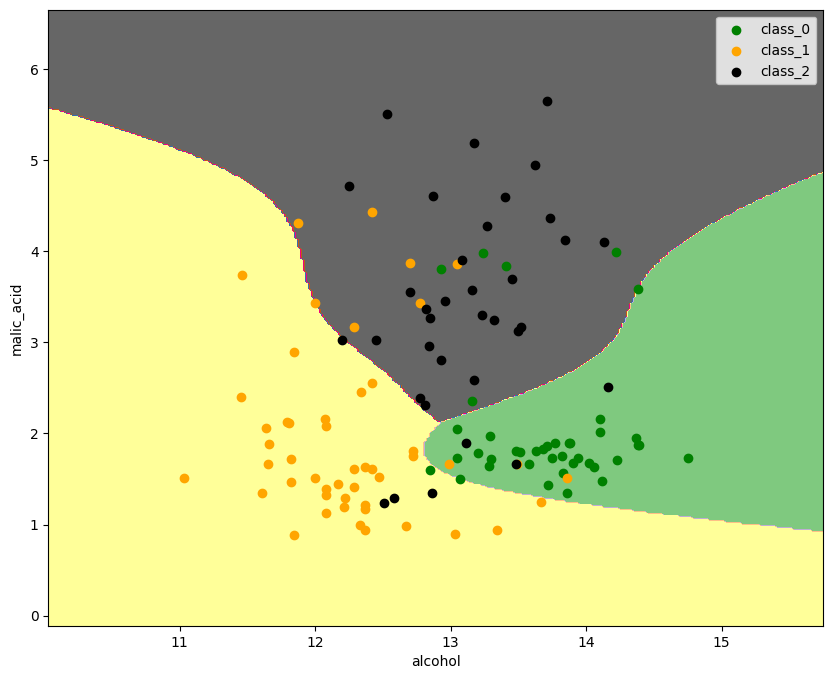

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = torch.meshgrid(torch.arange(x_min, x_max, plot_step, device=device),
    torch.arange(y_min, y_max, plot_step, device=device))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1).to(device))

preds_class = preds.cpu().data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx.cpu(), yy.cpu(), preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train.cpu() == i)
    plt.scatter(X_train.cpu()[indexes, 0],
                X_train.cpu()[indexes, 1], 
                c=color,
                label=wine.target_names[i],
                cmap='Accent')

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[1])
plt.legend()
plt.show()

## Завдання 1

Завантаження всіх даних

In [12]:
wine = sklearn.datasets.load_wine()
wine.data.shape

X_train, X_test, y_train, y_test = train_test_split(
    wine.data,
    wine.target,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

Оптимізація архітектури

In [13]:
import torch.nn as nn
import torch

class OptimizedWineNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(OptimizedWineNet, self).__init__()
        # Збільшуємо кількість вхідних нейронів для 13 ознак
        self.fc1 = nn.Linear(13, n_hidden_neurons)
        # Додаємо батч нормалізацію
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons)
        # Змінюємо функцію активації на ReLU
        self.activ1 = nn.ReLU()
        # Додаємо dropout для уникнення перенавчання
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons * 2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons * 2)
        self.activ2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc3 = nn.Linear(n_hidden_neurons * 2, n_hidden_neurons)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons)
        self.activ3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.3)
        
        self.fc4 = nn.Linear(n_hidden_neurons, 3)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activ3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

# Збільшуємо кількість нейронів до 64
wine_net = OptimizedWineNet(n_hidden_neurons=64).to(device)

Використаємо інший оптимізатор та функцію втрат, збільшуємо learning rate

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(wine_net.parameters(), lr=1.0e-5)

Навчання

In [15]:
batch_size = 10
epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    wine_net.train()
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = wine_net.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % (epochs / 10) == 0:
        train_losses.append(loss_value.item())
        wine_net.eval()
        with torch.no_grad():
            val_preds = wine_net.forward(X_test)
            val_loss_value = loss(val_preds, y_test)
            val_losses.append(val_loss_value.item())
        print(f'Epoch {epoch}, Train Loss: {loss_value.item()}, Val Loss: {val_loss_value.item()}')


Epoch 0, Train Loss: 1.2430179119110107, Val Loss: 1.1249772310256958
Epoch 100, Train Loss: 1.2907073497772217, Val Loss: 1.0733078718185425
Epoch 200, Train Loss: 1.1010849475860596, Val Loss: 1.0299879312515259
Epoch 300, Train Loss: 1.0497627258300781, Val Loss: 1.006661295890808
Epoch 400, Train Loss: 0.8847731947898865, Val Loss: 0.9656042456626892
Epoch 500, Train Loss: 1.075441837310791, Val Loss: 0.9492068290710449
Epoch 600, Train Loss: 0.8032044172286987, Val Loss: 0.8986508250236511
Epoch 700, Train Loss: 0.9974238872528076, Val Loss: 0.8867260813713074
Epoch 800, Train Loss: 0.7131157517433167, Val Loss: 0.8875899314880371
Epoch 900, Train Loss: 0.8809350728988647, Val Loss: 0.8505687713623047


Візуалізація результатів

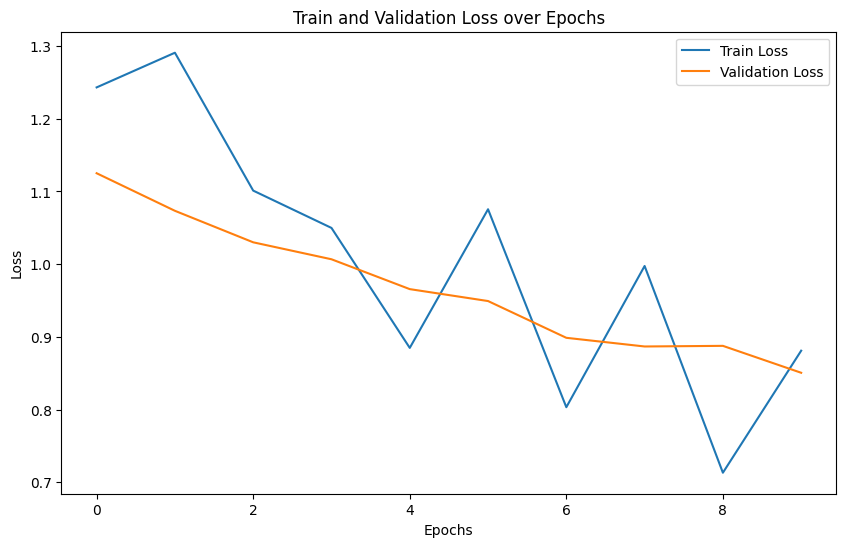

In [16]:
import matplotlib.pyplot as plt

# Побудова графіка втрат
plt.figure(figsize=(10, 6))

# Візуалізація втрат для тренувальних даних
plt.plot(train_losses, label='Train Loss')

# Візуалізація втрат для валідаційних даних
plt.plot(val_losses, label='Validation Loss')

# Додавання підписів
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()

# Показ графіку
plt.show()

На графіку можна побачити, що результати не є оптимальними. Але якщо змінити оптимізатор на Adam, то можна отримати результати краще

## Завдання 2

Завантажуємо дані

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target

df = pd.DataFrame(X, columns=data.feature_names)


Побудова кореляційної матриці

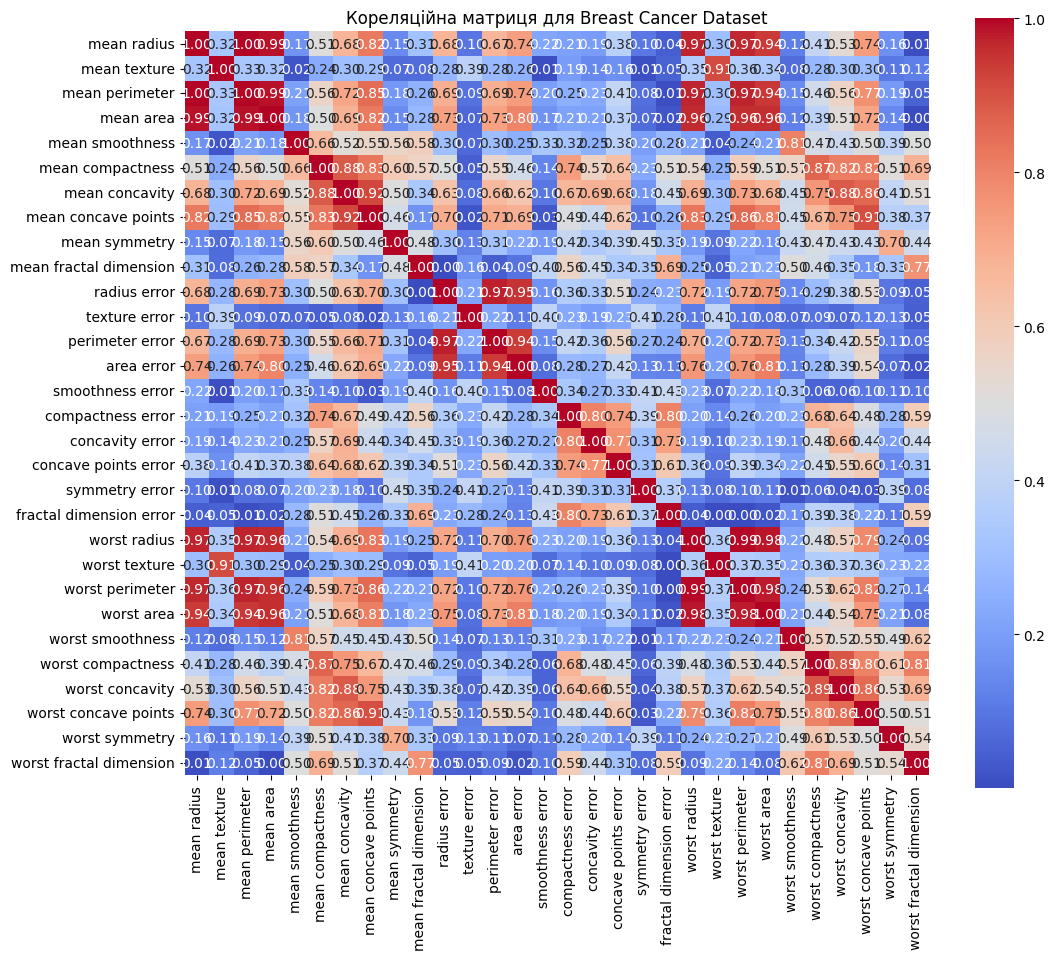

In [74]:
import seaborn as sns


corr_matrix = df.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Кореляційна матриця для Breast Cancer Dataset')
plt.show()

Видалення ознак, у яких корелляція Пірсона більша за 0.9

In [81]:
# Вибір верхнього трикутника матриці кореляцій
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_reduced = df.drop(to_drop, axis=1)

print("Ознаки після видалення")
print(*df_reduced.columns.tolist(), sep='\n')

Ознаки після видалення
mean radius
mean texture
mean smoothness
mean compactness
mean concavity
mean symmetry
mean fractal dimension
radius error
texture error
smoothness error
compactness error
concavity error
concave points error
symmetry error
fractal dimension error
worst smoothness
worst compactness
worst concavity
worst symmetry
worst fractal dimension


In [82]:
import torch
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = train_test_split(
    df_reduced.values,
    y,
    test_size=0.3,
    shuffle=True)

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

df_reduced.shape[1]

20

Створюємо мережу (схожу на попередню)

In [83]:
import torch.nn as nn
import torch

class CancerNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(CancerNet, self).__init__()
        self.fc1 = nn.Linear(20, n_hidden_neurons)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons)
        self.activ1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons * 2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons * 2)
        self.activ2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.fc3 = nn.Linear(n_hidden_neurons * 2, n_hidden_neurons)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons)
        self.activ3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.3)
        
        # Вихідний шар для бінарної класифікації
        self.fc4 = nn.Linear(n_hidden_neurons, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activ3(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

cancer_net = CancerNet(n_hidden_neurons=64).to(device)

Оптимізатор - Адам

In [84]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cancer_net.parameters(), lr=1.0e-5)

Навчання

In [85]:
import numpy as np


# Збільшимо розмір батча та кількість епох для більшої швидкості
batch_size = 32
epochs = 2000
train_losses = []
val_losses = []

for epoch in range(epochs):
    cancer_net.train()
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = cancer_net.forward(x_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    if epoch % (epochs / 10) == 0:
        train_losses.append(loss_value.item())
        cancer_net.eval()
        with torch.no_grad():
            val_preds = cancer_net.forward(X_test)
            val_loss_value = loss(val_preds, y_test)
            val_losses.append(val_loss_value.item())
        print(f'Epoch {epoch}, Train Loss: {loss_value.item()}, Val Loss: {val_loss_value.item()}')


Epoch 0, Train Loss: 0.8648590445518494, Val Loss: 0.6984931230545044


Epoch 200, Train Loss: 0.3321833610534668, Val Loss: 0.29054951667785645
Epoch 400, Train Loss: 0.2675440013408661, Val Loss: 0.22466187179088593
Epoch 600, Train Loss: 0.24846501648426056, Val Loss: 0.17740288376808167
Epoch 800, Train Loss: 0.2170056849718094, Val Loss: 0.1662237048149109
Epoch 1000, Train Loss: 0.36541441082954407, Val Loss: 0.1604006588459015
Epoch 1200, Train Loss: 0.37292715907096863, Val Loss: 0.14710302650928497
Epoch 1400, Train Loss: 0.14796733856201172, Val Loss: 0.1474088728427887
Epoch 1600, Train Loss: 0.11472304165363312, Val Loss: 0.14817754924297333
Epoch 1800, Train Loss: 0.14419220387935638, Val Loss: 0.1443139612674713


Візуалізація

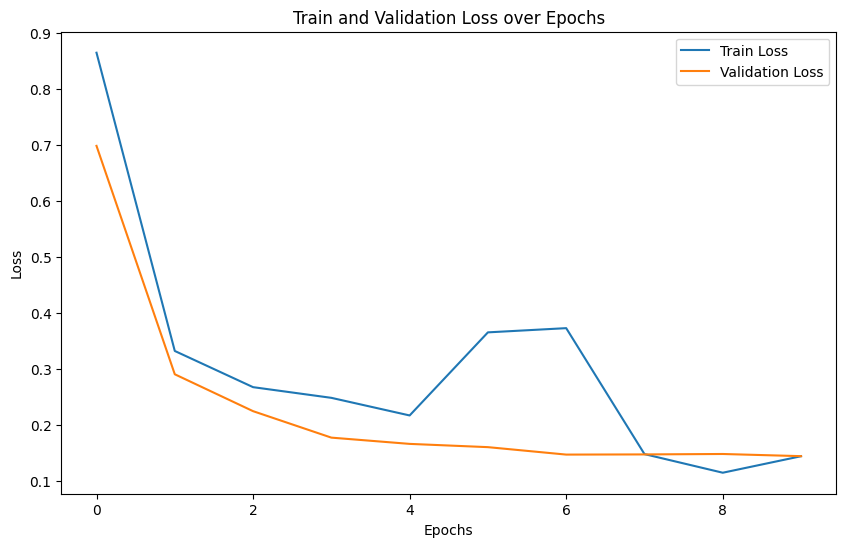

In [86]:
import matplotlib.pyplot as plt

# Побудова графіка втрат
plt.figure(figsize=(10, 6))

# Візуалізація втрат для тренувальних даних
plt.plot(train_losses, label='Train Loss')

# Візуалізація втрат для валідаційних даних
plt.plot(val_losses, label='Validation Loss')

# Додавання підписів
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()

# Показ графіку
plt.show()

Модель навчилася добре, 1600 епох буде достатньо для уникнення перенавчання